# Estimates of power consumption

## AEP DATASETS

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [162]:
df = pd.read_csv('archive/Combine_hourly_est.csv', usecols=['Datetime', 'AEP'], low_memory=False)

# Convert 'Datetime' column to datetime format and set it as the index
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

print(df)

                         AEP
Datetime                    
1998-12-31 01:00:00      NaN
1998-12-31 02:00:00      NaN
1998-12-31 03:00:00      NaN
1998-12-31 04:00:00      NaN
1998-12-31 05:00:00      NaN
...                      ...
2018-01-01 20:00:00  21089.0
2018-01-01 21:00:00  20999.0
2018-01-01 22:00:00  20820.0
2018-01-01 23:00:00  20415.0
2018-01-02 00:00:00  19993.0

[178262 rows x 1 columns]


# Data Preprocessing

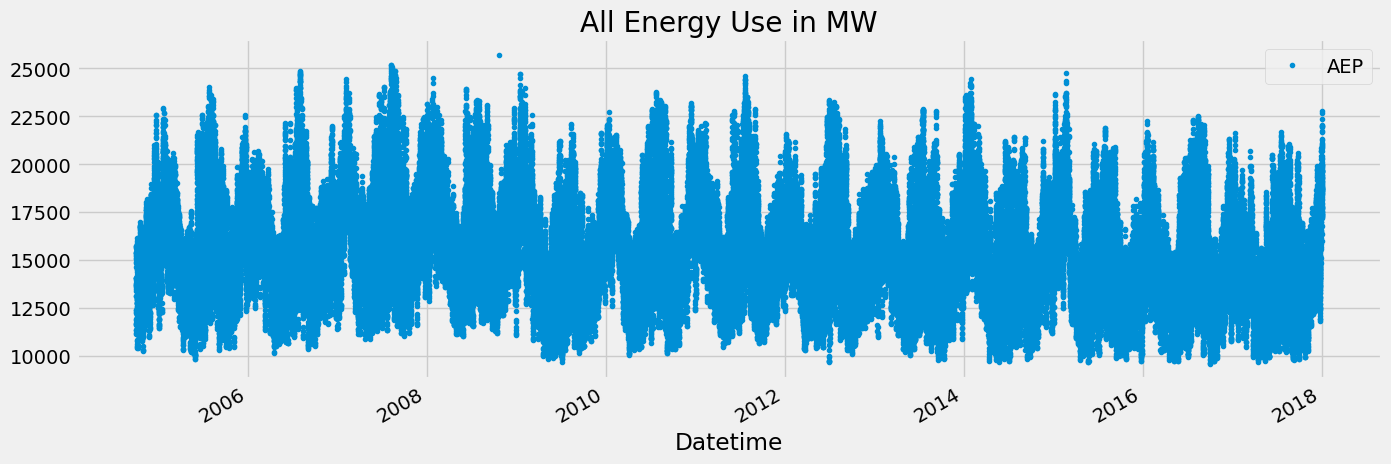

In [163]:
aep_data = df.copy()

aep_data= aep_data.loc['1998-12-31':'2018-01-02'] #display from 1998-2018 datetime

aep_data.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='All Energy Use in MW')
plt.show()

In [164]:
aep_data  = aep_data.loc[~np.isinf(aep_data ['AEP']), :]
aep_data  = aep_data.dropna(subset=['AEP']) #drop NaN
# Check for NaN and infinity values
print(aep_data['AEP'].isnull().sum())  # Check for NaN values
print(np.isinf(aep_data['AEP']).sum()) # Check for infinity values
print(aep_data['AEP'].max())           # Check the maximum value

0
0
25695.0


# Model Selection

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Splitting the data into training and testing sets
X = aep_data.index.astype(int).values.reshape(-1, 1)  # Converting datetime to integer for linear regression
y = aep_data['AEP'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate the model
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)

print(f'Training RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Training RMSE: 2542.9407427427186
Test RMSE: 2560.439930108739


In [98]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


# Binarize 'PJMW' column for binary classification
aep_data['AEP_binary'] = aep_data['AEP'].apply(lambda x: 1 if x >= aep_data['AEP'].mean() else 0)

# Splitting the data into training and testing sets
X = aep_data.index.astype(int).values.reshape(-1, 1)  # Converting datetime to integer for logistic regression
y = aep_data['AEP_binary'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f'Training Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

# Classification report
print("Classification Report for Test Set:")
print(classification_report(y_test, y_pred_test))

Training Accuracy: 0.5307376167319361
Test Accuracy: 0.5277359383741447
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.53      1.00      0.69     12263
           1       0.00      0.00      0.00     10974

    accuracy                           0.53     23237
   macro avg       0.26      0.50      0.35     23237
weighted avg       0.28      0.53      0.36     23237



C:\Users\CICI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\CICI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\CICI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Train / Test Split

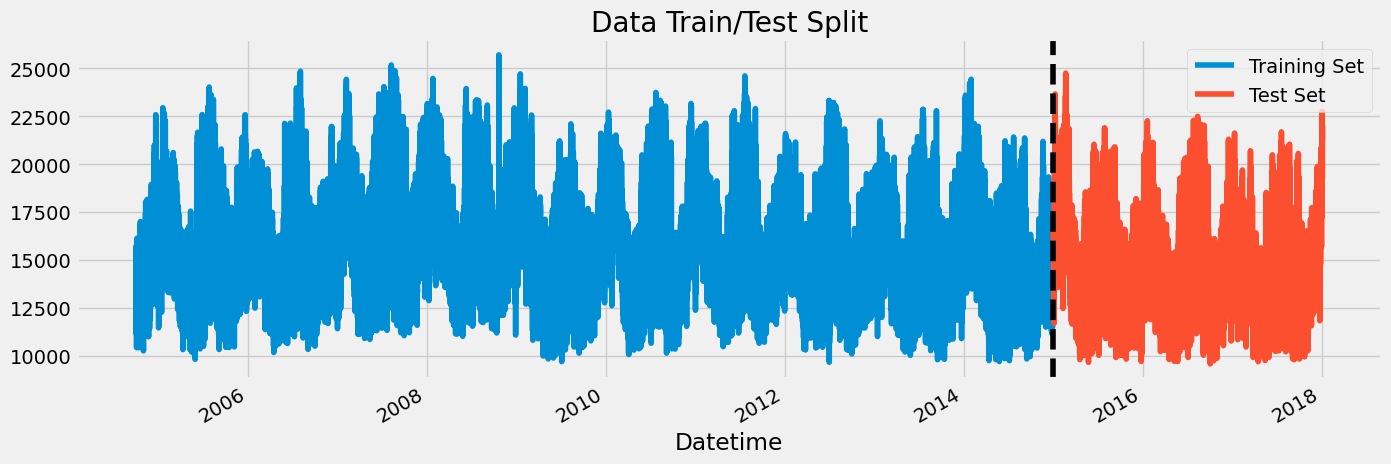

In [165]:
train = aep_data.loc[aep_data.index < '01-01-2015']
test = aep_data.loc[aep_data.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

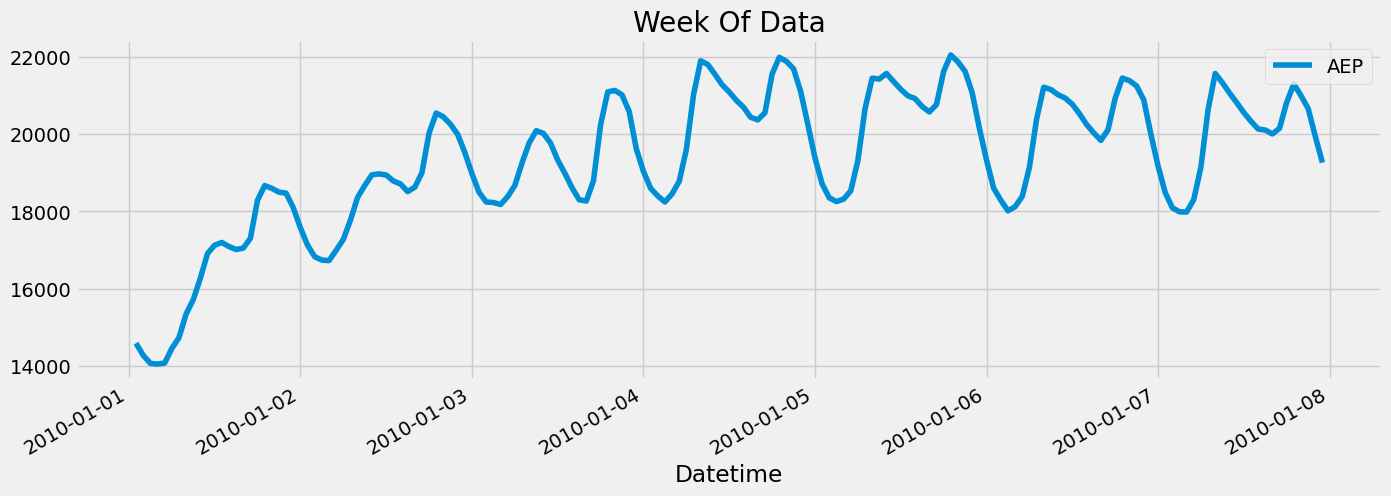

In [166]:
aep_data.loc[(aep_data.index > '01-01-2010') & (aep_data.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

# Feature Creation

In [167]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = aep_data.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# Visualize our Feature / Target Relationship

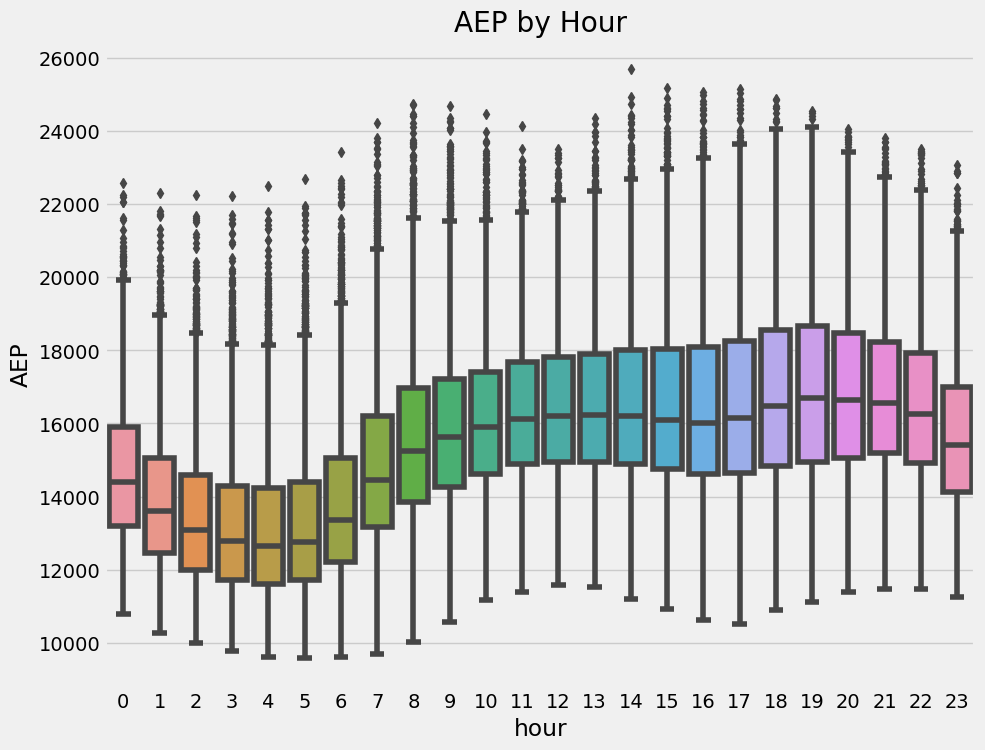

In [168]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='AEP')
ax.set_title('AEP by Hour')
plt.show()

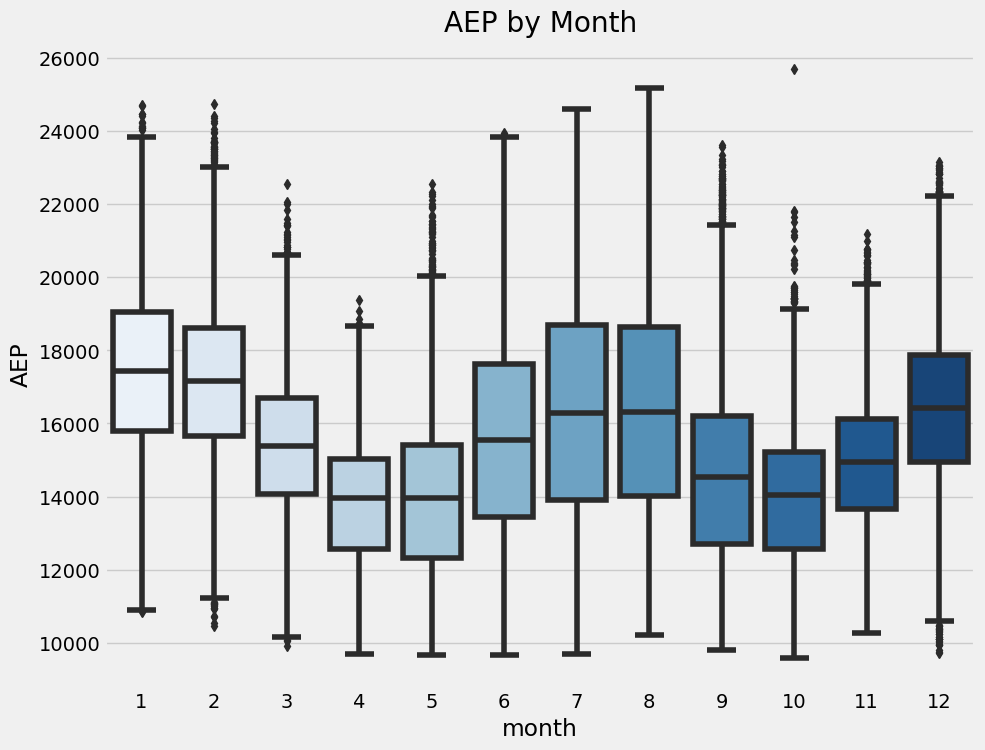

In [169]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='AEP', palette='Blues')
ax.set_title('AEP by Month')
plt.show()

# Create our Model

In [170]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'AEP'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [171]:
import warnings

# Suppress XGBoost warning
warnings.filterwarnings('ignore', message=".*reg:linear.*", category=UserWarning)

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:15571.07325	validation_1-rmse:15571.07325
[100]	validation_0-rmse:5965.32183	validation_1-rmse:5965.32183
[200]	validation_0-rmse:2710.31730	validation_1-rmse:2710.31730
[300]	validation_0-rmse:1785.79000	validation_1-rmse:1785.79000
[400]	validation_0-rmse:1549.41898	validation_1-rmse:1549.41898
[500]	validation_0-rmse:1468.94494	validation_1-rmse:1468.94494
[600]	validation_0-rmse:1427.80280	validation_1-rmse:1427.80280
[700]	validation_0-rmse:1397.56856	validation_1-rmse:1397.56856
[800]	validation_0-rmse:1373.84774	validation_1-rmse:1373.84774
[900]	validation_0-rmse:1357.58892	validation_1-rmse:1357.58892
[999]	validation_0-rmse:1342.07196	validation_1-rmse:1342.07196


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

# Feature Importance

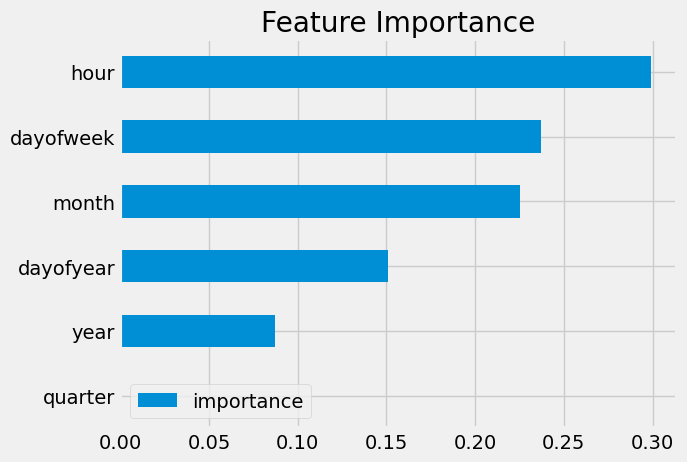

In [172]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test

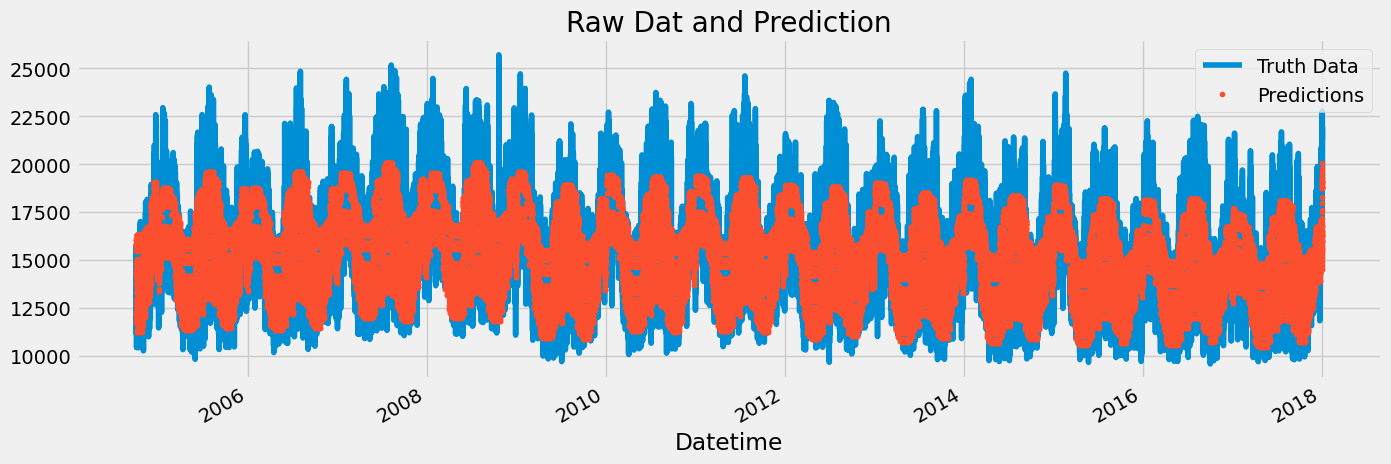

In [173]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['AEP']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

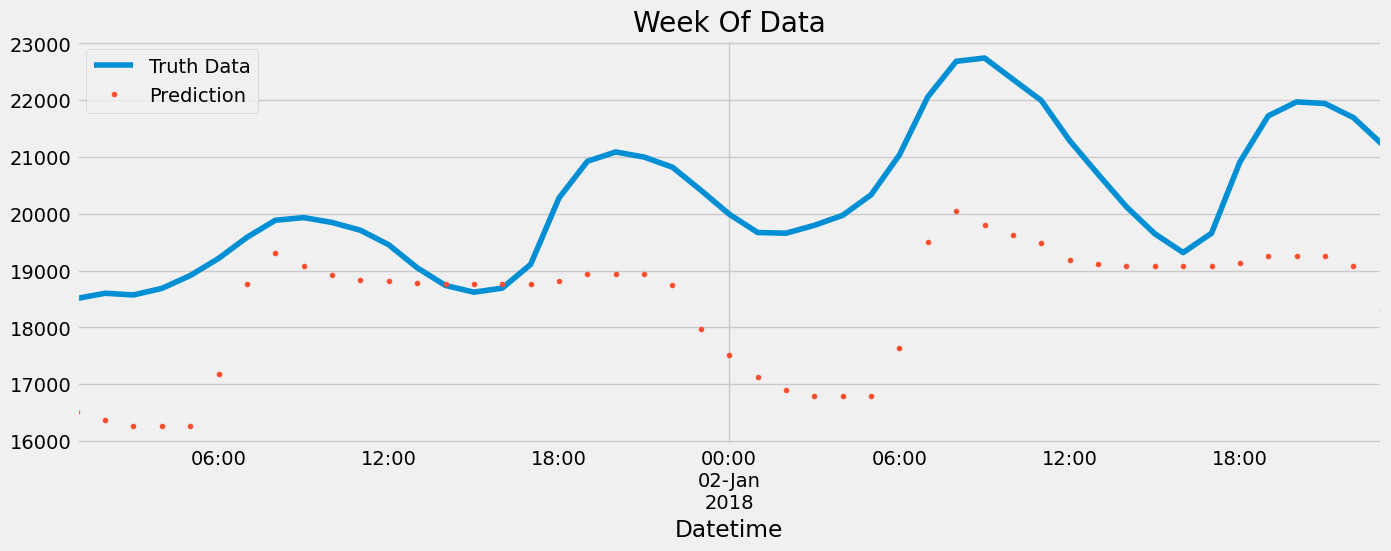

In [174]:
ax = df.loc[(df.index > '01-01-2018') & (df.index < '01-08-2018')]['AEP'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '01-01-2018') & (df.index < '01-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# Score (RMSE)

In [175]:
score = np.sqrt(mean_squared_error(test['AEP'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1342.07


# Calculate Error
- Look at the worst and best predicted days

In [176]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2015-02-19    4852.537435
2015-02-20    4712.839600
2009-01-16    4320.399089
2014-01-07    4206.639160
2008-12-22    4154.567057
2007-02-06    4113.479736
2017-01-08    4108.332438
2010-12-14    3978.519491
2015-01-08    3969.494059
2014-11-18    3950.618896
Name: error, dtype: float64

# Final accuracy

In [177]:
r2 = r2_score(y_test, test['prediction'])

print(f'Final R-squared: {r2}')

Final R-squared: 0.7325725139379133


## COMED DATASETS

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

df = pd.read_csv('archive/Combine_hourly_est.csv', usecols=['Datetime', 'COMED'], low_memory=False)

# Convert 'Datetime' column to datetime format and set it as the index
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

print(df)

                       COMED
Datetime                    
1998-12-31 01:00:00      NaN
1998-12-31 02:00:00      NaN
1998-12-31 03:00:00      NaN
1998-12-31 04:00:00      NaN
1998-12-31 05:00:00      NaN
...                      ...
2018-01-01 20:00:00  13858.0
2018-01-01 21:00:00  13758.0
2018-01-01 22:00:00  13627.0
2018-01-01 23:00:00  13336.0
2018-01-02 00:00:00  12816.0

[178262 rows x 1 columns]


# Data Preprocessing

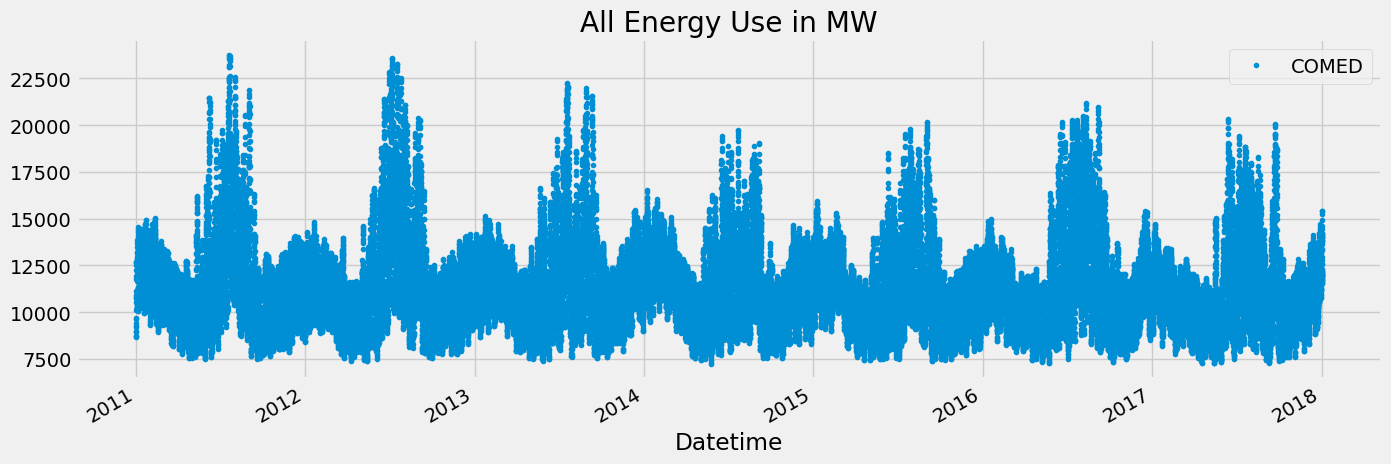

In [115]:
comed_data = df.copy()

comed_data = comed_data.loc['1998-12-31':'2018-01-02'] #display from 1998-2018 datetime

comed_data.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='All Energy Use in MW')
plt.show()

In [117]:
comed_data  = comed_data.loc[~np.isinf(comed_data['COMED']), :]
comed_data  = comed_data.dropna(subset=['COMED']) #drop NaN
# Check for NaN and infinity values
print(comed_data['COMED'].isnull().sum())  # Check for NaN values
print(np.isinf(comed_data['COMED']).sum()) # Check for infinity values
print(comed_data['COMED'].max())           # Check the maximum value

0
0
23753.0


# Model Selection

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Splitting the data into training and testing sets
X = comed_data.index.astype(int).values.reshape(-1, 1)  # Converting datetime to integer for linear regression
y = comed_data['COMED'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate the model
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)

print(f'Training RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Training RMSE: 2298.639077318681
Test RMSE: 2312.7422458166125


In [119]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


# Binarize for binary classification
comed_data['COMED_binary'] = comed_data['COMED'].apply(lambda x: 1 if x >= comed_data['COMED'].mean() else 0)

# Splitting the data into training and testing sets
X = comed_data.index.astype(int).values.reshape(-1, 1)  # Converting datetime to integer for logistic regression
y = comed_data['COMED_binary'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f'Training Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

# Classification report
print("Classification Report for Test Set:")
print(classification_report(y_test, y_pred_test))

Training Accuracy: 0.5605471532965579
Test Accuracy: 0.5586223742061553
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.56      1.00      0.72      6861
           1       0.00      0.00      0.00      5421

    accuracy                           0.56     12282
   macro avg       0.28      0.50      0.36     12282
weighted avg       0.31      0.56      0.40     12282



C:\Users\CICI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\CICI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\CICI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Train / Test Split

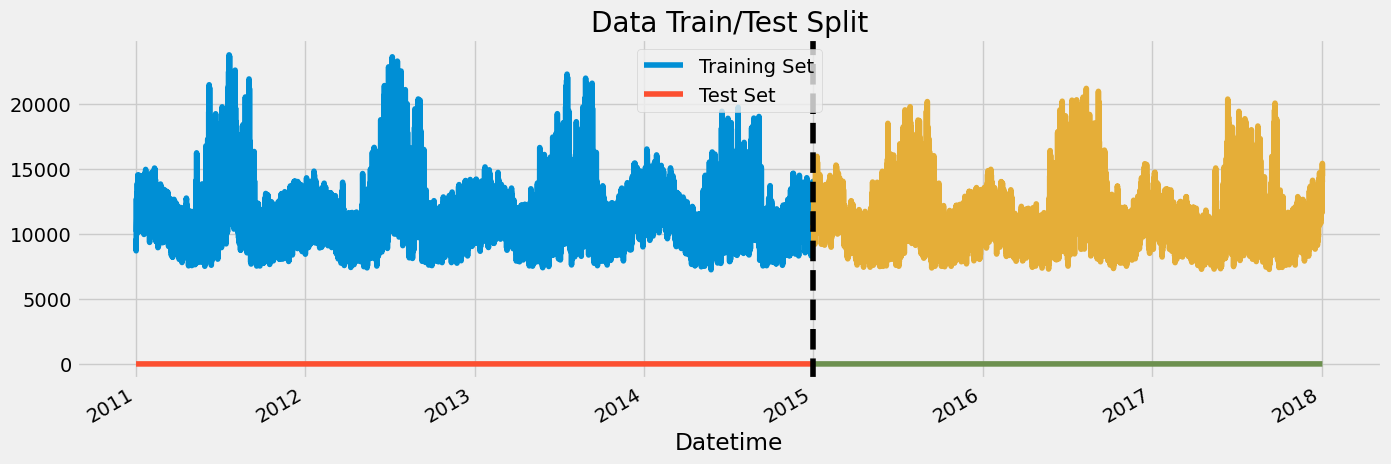

In [120]:
train = comed_data.loc[comed_data.index < '01-01-2015']
test = comed_data.loc[comed_data.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

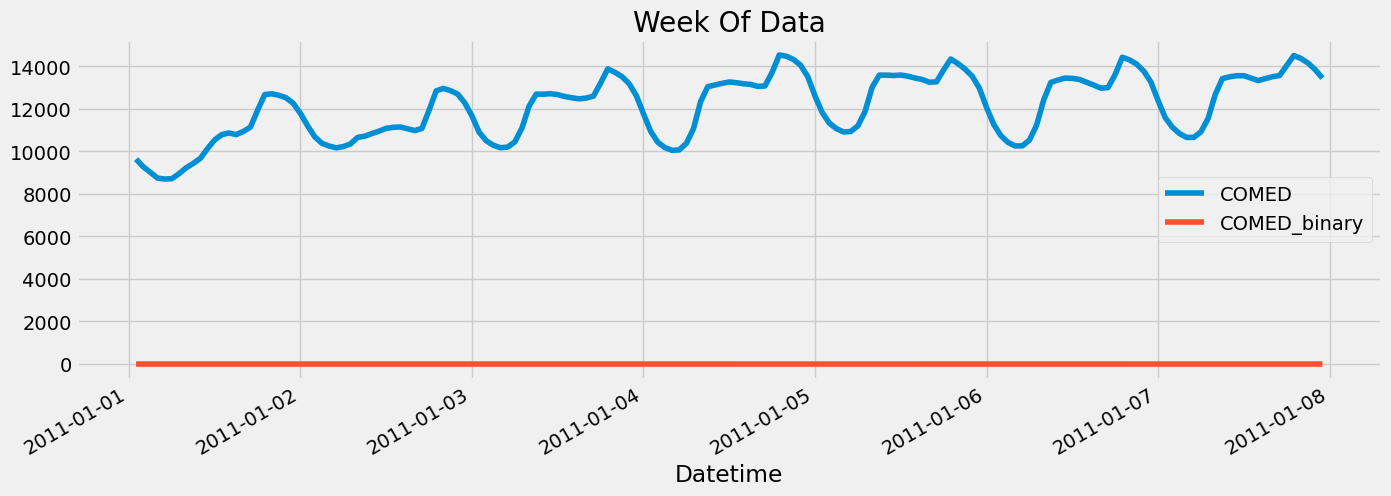

In [122]:
comed_data.loc[(comed_data.index > '01-01-2011') & (comed_data.index < '01-08-2011')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

# Feature Creation

In [123]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = comed_data.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# Visualize our Feature / Target Relationship

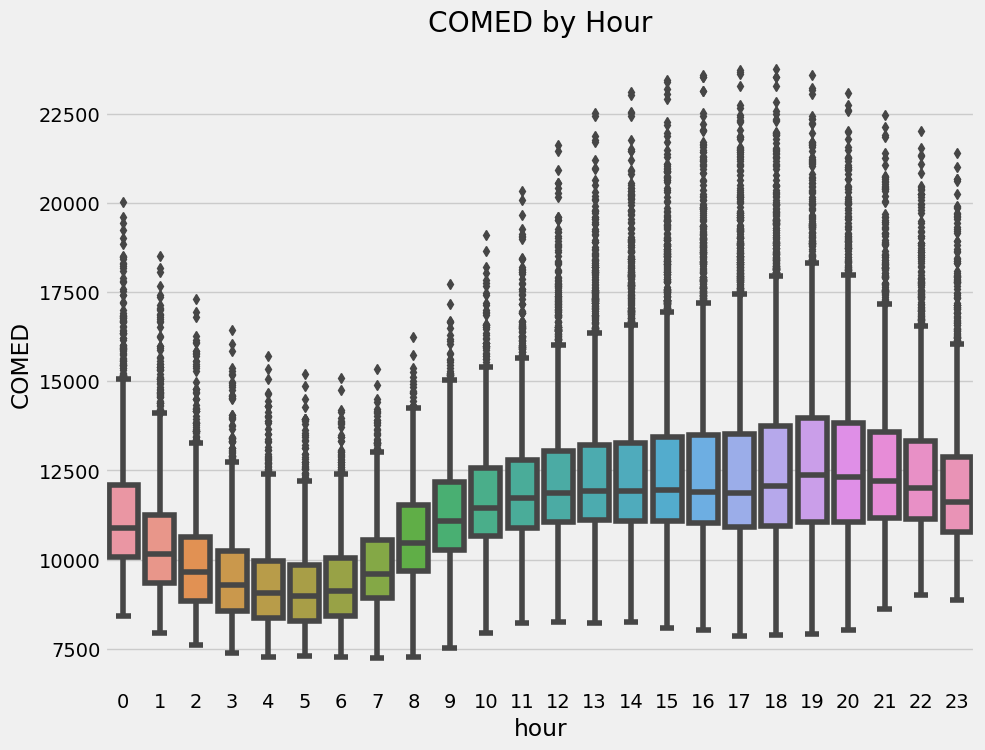

In [124]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='COMED')
ax.set_title('COMED by Hour')
plt.show()

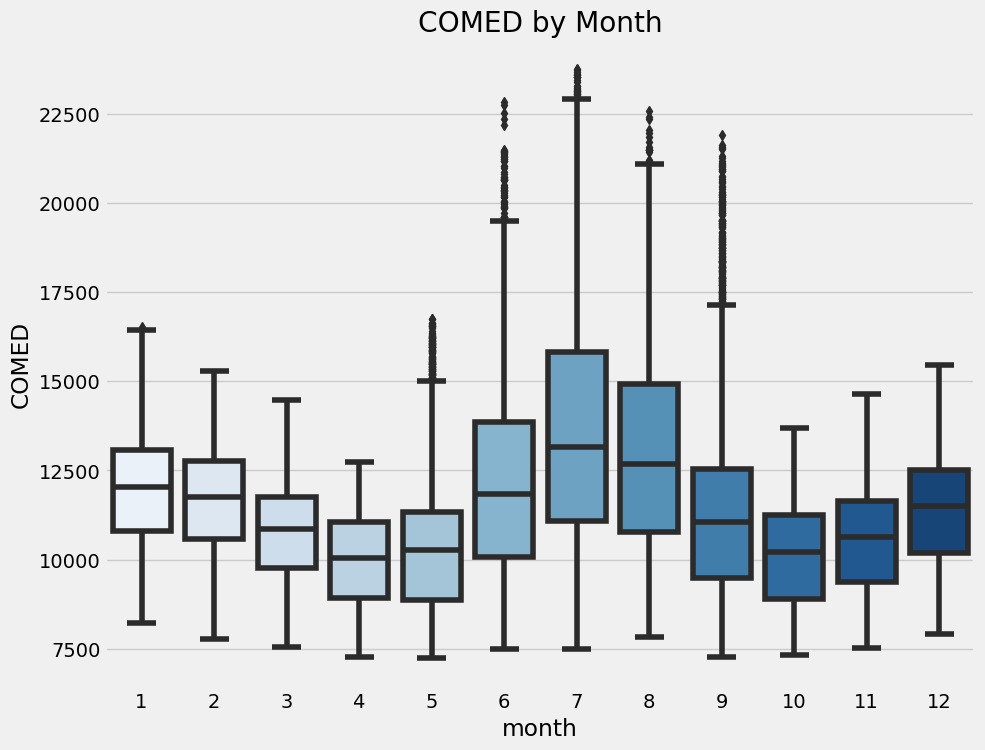

In [125]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='COMED', palette='Blues')
ax.set_title('COMED by Month')
plt.show()

# Create our Model

In [126]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'COMED'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [127]:
import warnings

# Suppress XGBoost warning
warnings.filterwarnings('ignore', message=".*reg:linear.*", category=UserWarning)

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:11533.75461	validation_1-rmse:11533.75461
[100]	validation_0-rmse:4476.75998	validation_1-rmse:4476.75998
[200]	validation_0-rmse:2124.94813	validation_1-rmse:2124.94813
[300]	validation_0-rmse:1479.43681	validation_1-rmse:1479.43681
[400]	validation_0-rmse:1322.28859	validation_1-rmse:1322.28859
[500]	validation_0-rmse:1263.16874	validation_1-rmse:1263.16874
[600]	validation_0-rmse:1233.70876	validation_1-rmse:1233.70876
[700]	validation_0-rmse:1212.44457	validation_1-rmse:1212.44457
[800]	validation_0-rmse:1194.29153	validation_1-rmse:1194.29153
[900]	validation_0-rmse:1176.35531	validation_1-rmse:1176.35531
[999]	validation_0-rmse:1166.76963	validation_1-rmse:1166.76963


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

# Feature Importance

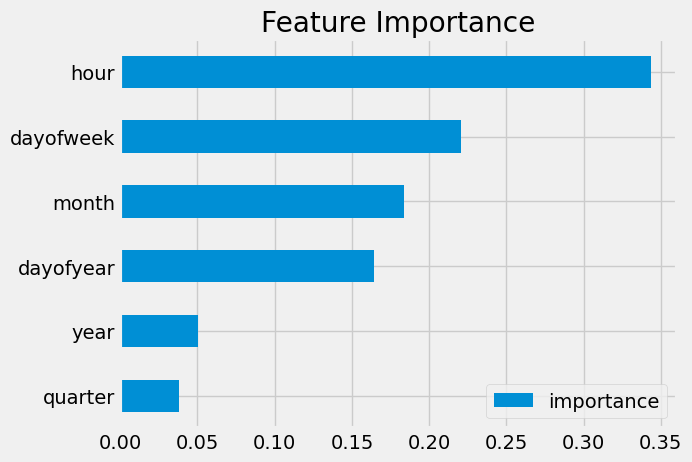

In [131]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test

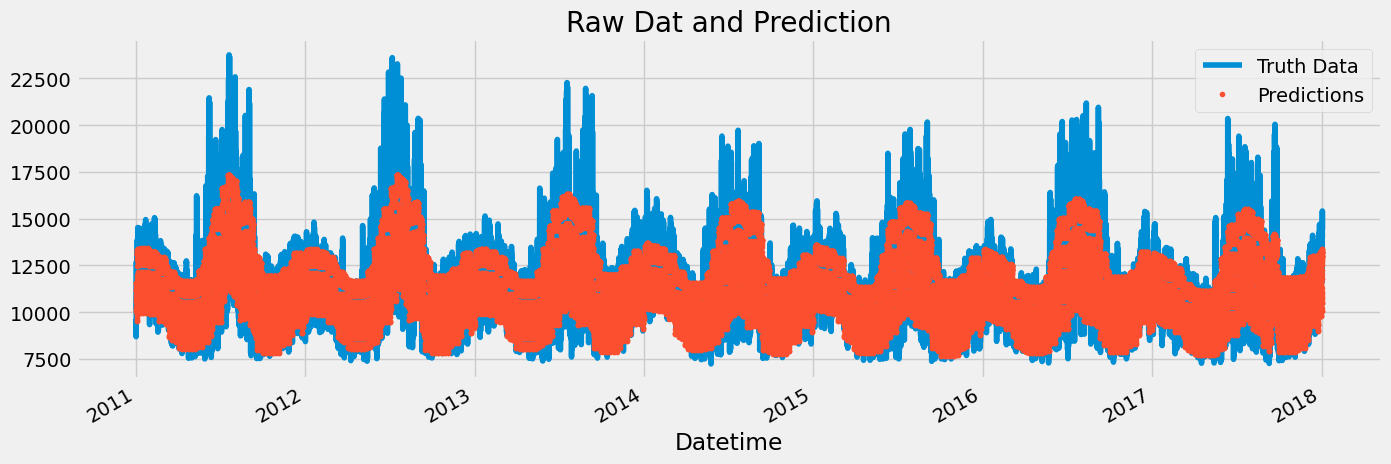

In [132]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['COMED']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

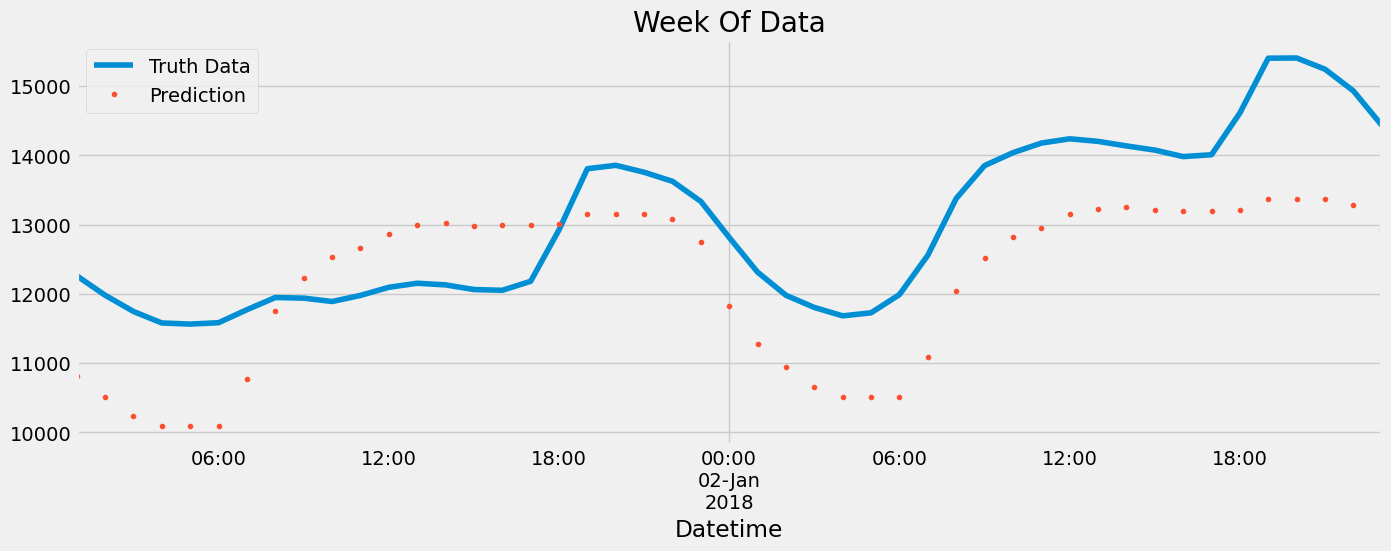

In [134]:
ax = df.loc[(df.index > '01-01-2018') & (df.index < '01-08-2018')]['COMED'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '01-01-2018') & (df.index < '01-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# Score (RMSE)

In [135]:
score = np.sqrt(mean_squared_error(test['COMED'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1166.77


# Calculate Error

In [136]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2012-07-06    5352.217692
2011-06-08    5287.304728
2011-06-07    5082.297892
2013-09-10    4855.963542
2011-07-21    4742.078328
2013-07-19    4468.970174
2012-07-03    4416.021118
2012-07-05    4308.308919
2012-06-28    4246.432617
2013-07-18    4235.118083
Name: error, dtype: float64

# Final accuracy

In [137]:
r2 = r2_score(y_test, test['prediction'])

print(f'Final R-squared: {r2}')

Final R-squared: 0.7446096739394144


# DAYTON DATASETS

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

df = pd.read_csv('archive/Combine_hourly_est.csv', usecols=['Datetime', 'DAYTON'], low_memory=False)

# Convert 'Datetime' column to datetime format and set it as the index
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

print(df)

                     DAYTON
Datetime                   
1998-12-31 01:00:00     NaN
1998-12-31 02:00:00     NaN
1998-12-31 03:00:00     NaN
1998-12-31 04:00:00     NaN
1998-12-31 05:00:00     NaN
...                     ...
2018-01-01 20:00:00  2732.0
2018-01-01 21:00:00  2724.0
2018-01-01 22:00:00  2664.0
2018-01-01 23:00:00  2614.0
2018-01-02 00:00:00  2552.0

[178262 rows x 1 columns]


# Data Preprocessing

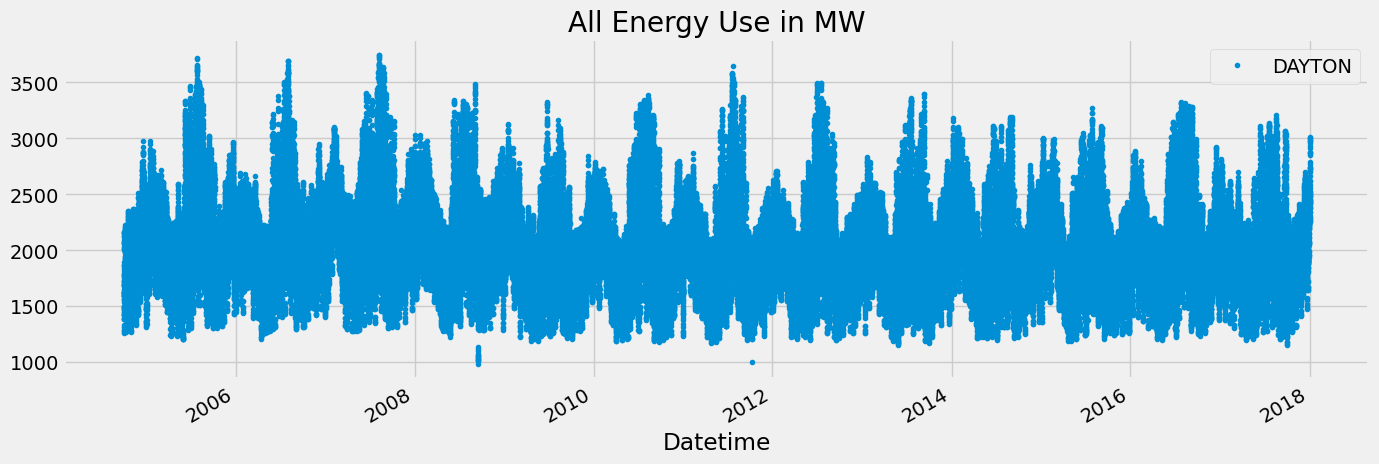

In [140]:
dayton_data = df.copy()

dayton_data = dayton_data.loc['1998-12-31':'2018-01-02'] #display from 1998-2018 datetime

dayton_data.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='All Energy Use in MW')
plt.show()

In [142]:
dayton_data  = dayton_data.loc[~np.isinf(dayton_data['DAYTON']), :]
dayton_data  = dayton_data.dropna(subset=['DAYTON']) #drop NaN

# Check for NaN and infinity values
print(dayton_data['DAYTON'].isnull().sum())  # Check for NaN values
print(np.isinf(dayton_data['DAYTON']).sum()) # Check for infinity values
print(dayton_data['DAYTON'].max())           # Check the maximum value

0
0
3746.0


# Model Selection

In [143]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Splitting the data into training and testing sets
X = dayton_data.index.astype(int).values.reshape(-1, 1)  # Converting datetime to integer for linear regression
y = dayton_data['DAYTON'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate the model
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)

print(f'Training RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Training RMSE: 391.16465518990856
Test RMSE: 394.1292267287299


In [145]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


# Binarize for binary classification
dayton_data['DAYTON_binary'] = dayton_data['DAYTON'].apply(lambda x: 1 if x >= dayton_data['DAYTON'].mean() else 0)

# Splitting the data into training and testing sets
X = dayton_data.index.astype(int).values.reshape(-1, 1)  # Converting datetime to integer for logistic regression
y = dayton_data['DAYTON_binary'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f'Training Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

# Classification report
print("Classification Report for Test Set:")
print(classification_report(y_test, y_pred_test))

Training Accuracy: 0.5295914964120109
Test Accuracy: 0.5335657113348825
Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.53      1.00      0.70     12399
           1       0.00      0.00      0.00     10839

    accuracy                           0.53     23238
   macro avg       0.27      0.50      0.35     23238
weighted avg       0.28      0.53      0.37     23238



C:\Users\CICI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\CICI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\CICI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Train / Test Split

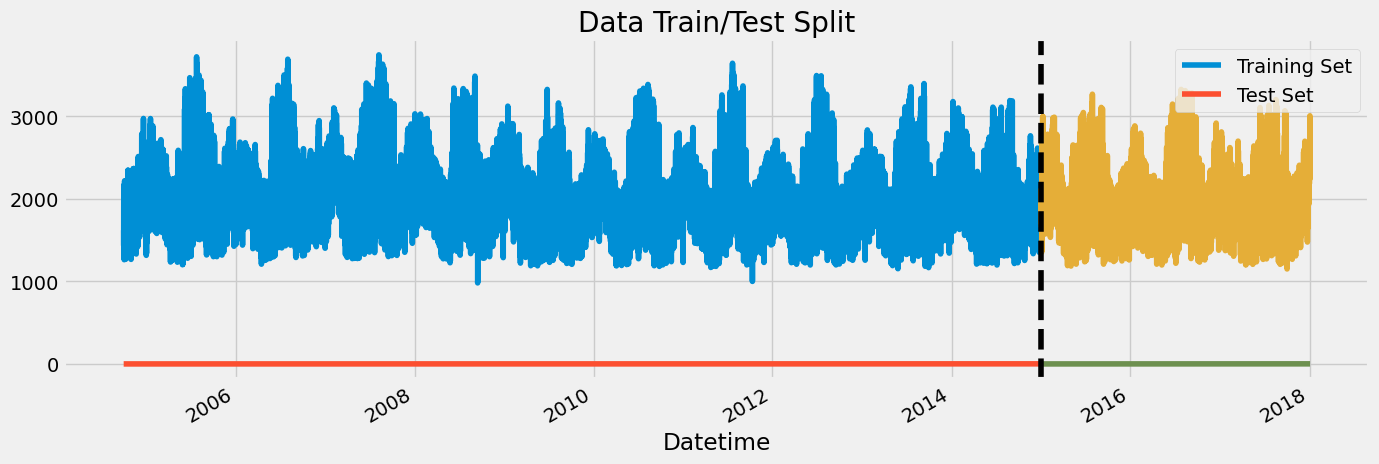

In [146]:
train = dayton_data.loc[dayton_data.index < '01-01-2015']
test = dayton_data.loc[dayton_data.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

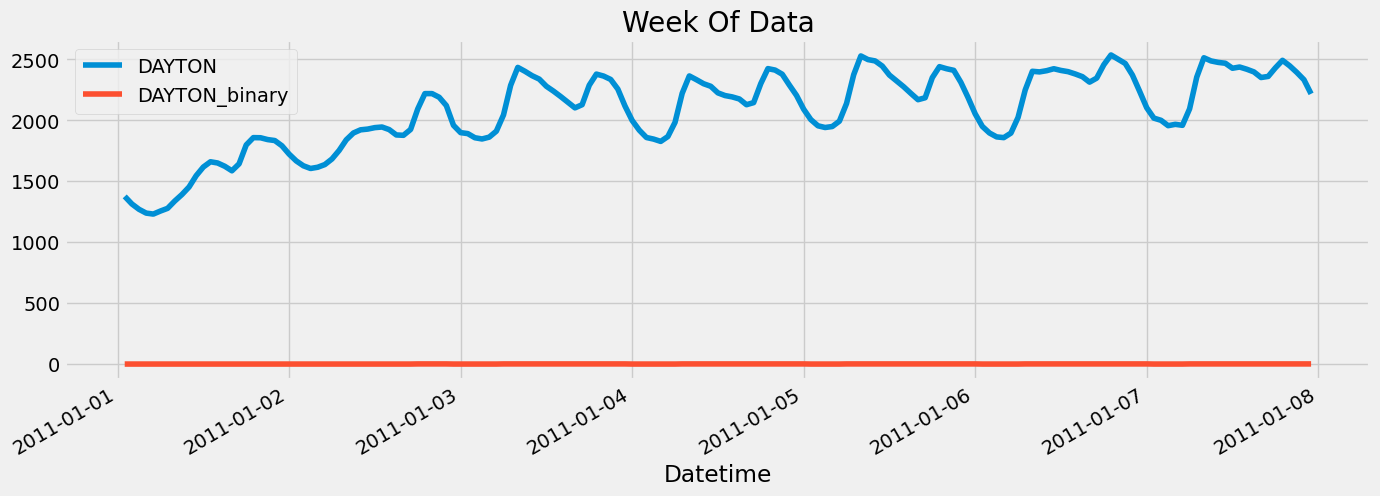

In [147]:
dayton_data.loc[(dayton_data.index > '01-01-2011') & (dayton_data.index < '01-08-2011')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

# Feature Creation

In [148]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = dayton_data.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# Visualize our Feature / Target Relationship

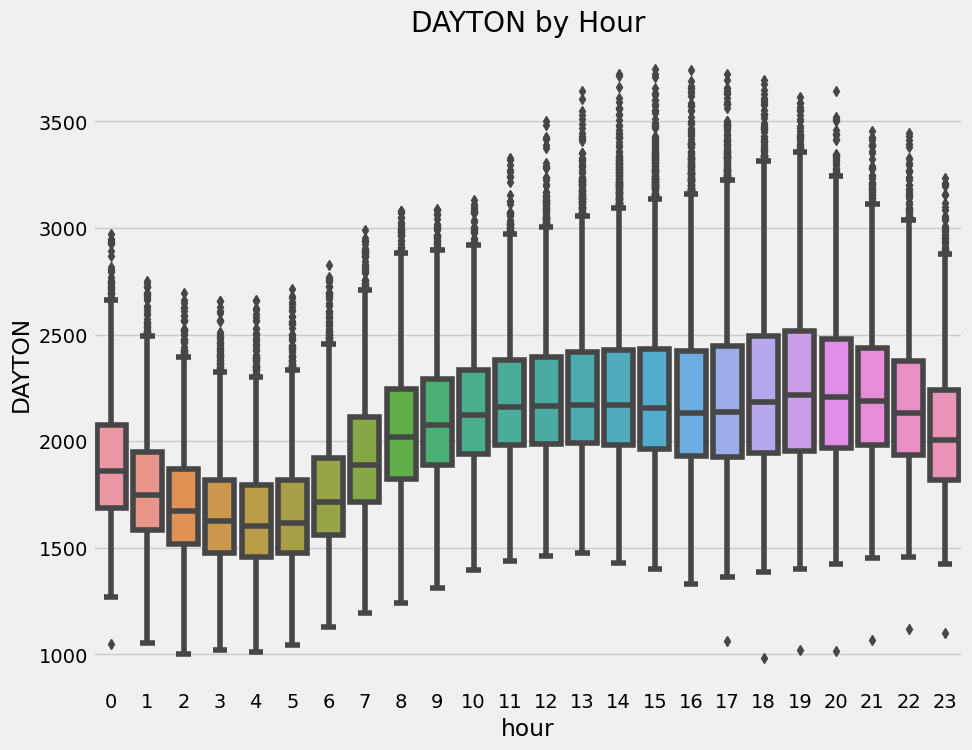

In [150]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='DAYTON')
ax.set_title('DAYTON by Hour')
plt.show()

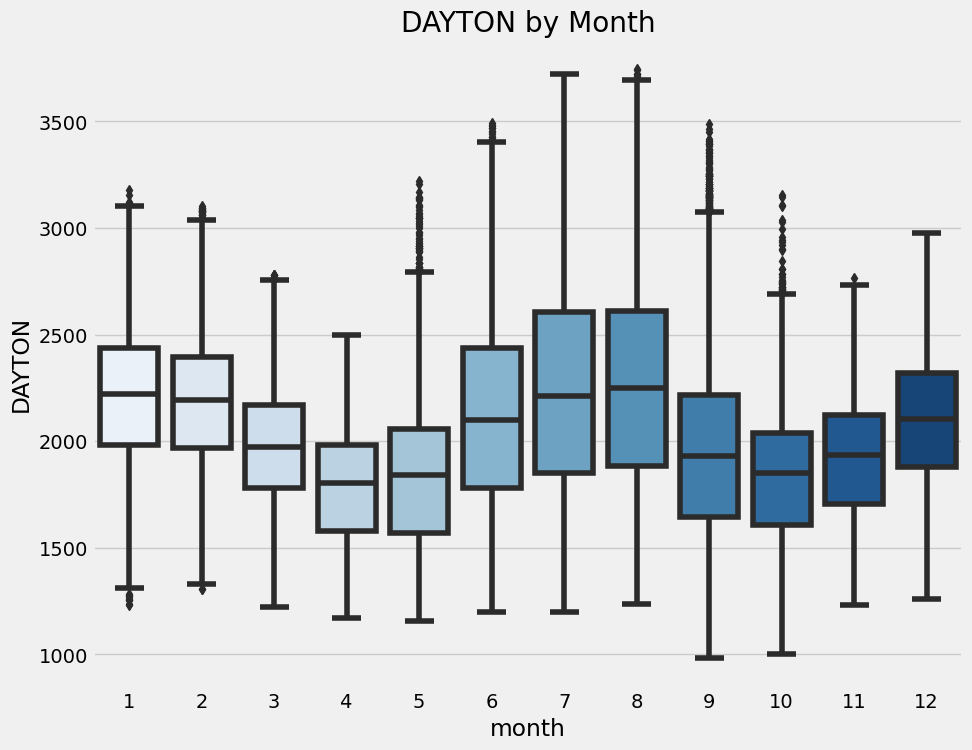

In [151]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='DAYTON', palette='Blues')
ax.set_title('DAYTON by Month')
plt.show()

# Create our Model

In [152]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'DAYTON'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [153]:
import warnings

# Suppress XGBoost warning
warnings.filterwarnings('ignore', message=".*reg:linear.*", category=UserWarning)

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:2053.97231	validation_1-rmse:2053.97231
[100]	validation_0-rmse:796.48594	validation_1-rmse:796.48594
[200]	validation_0-rmse:374.70584	validation_1-rmse:374.70584
[300]	validation_0-rmse:257.61663	validation_1-rmse:257.61663
[400]	validation_0-rmse:227.09174	validation_1-rmse:227.09174
[500]	validation_0-rmse:217.01035	validation_1-rmse:217.01035
[600]	validation_0-rmse:212.00407	validation_1-rmse:212.00407
[700]	validation_0-rmse:208.05216	validation_1-rmse:208.05216
[800]	validation_0-rmse:205.41921	validation_1-rmse:205.41921
[900]	validation_0-rmse:203.44949	validation_1-rmse:203.44949
[999]	validation_0-rmse:201.56173	validation_1-rmse:201.56173


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

# Feature Importance

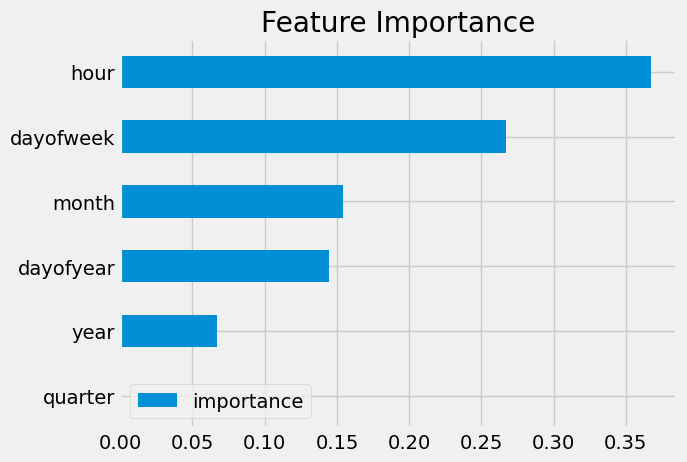

In [154]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test

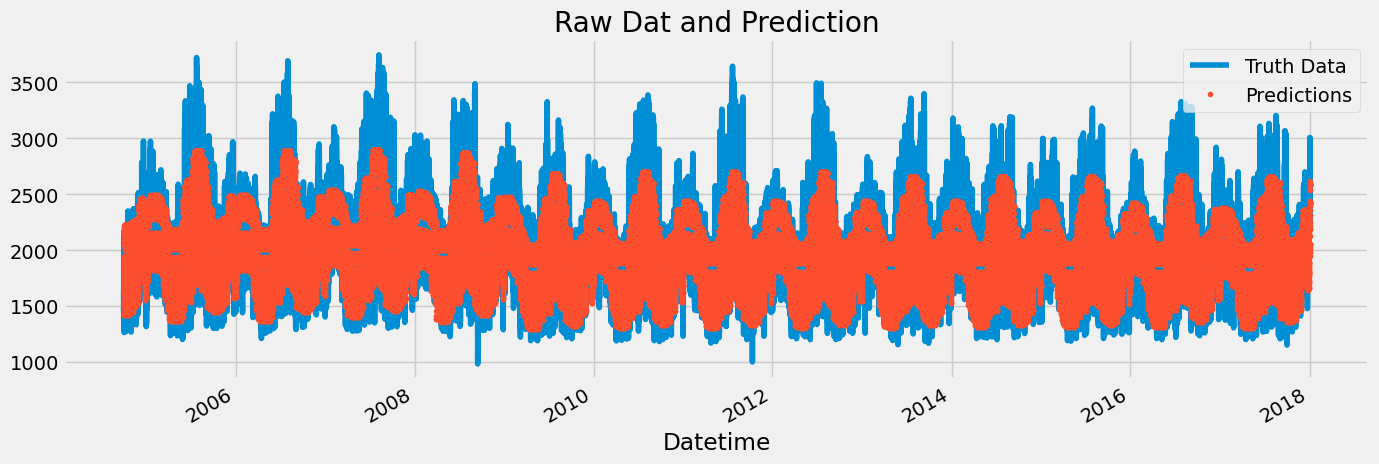

In [155]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['DAYTON']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

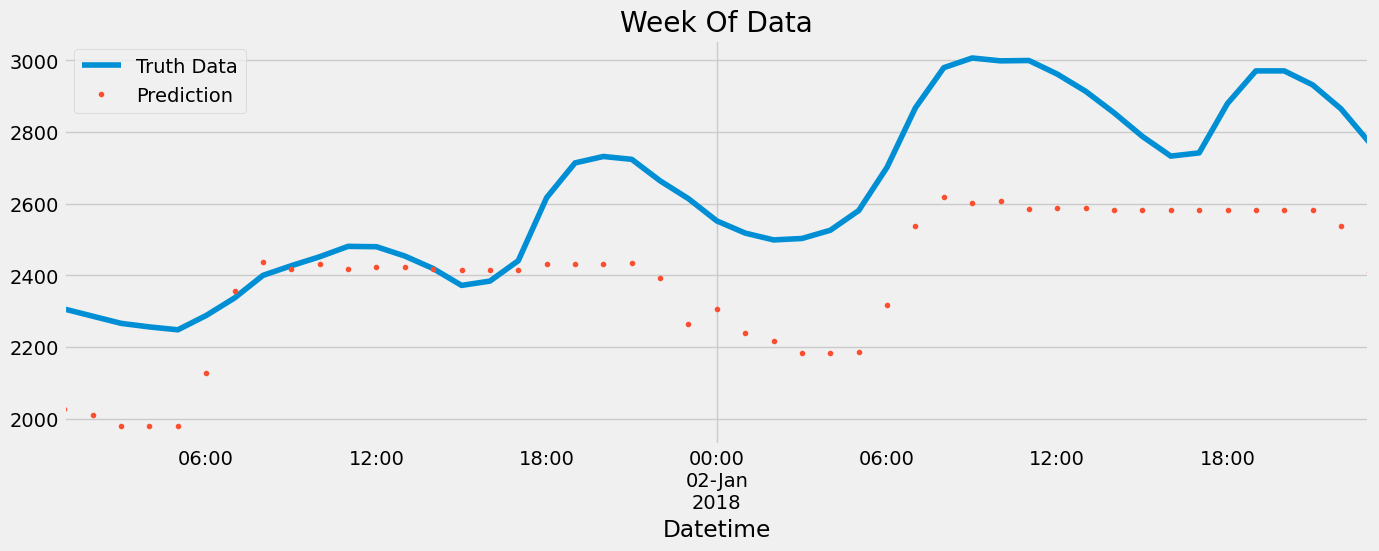

In [157]:
ax = df.loc[(df.index > '01-01-2018') & (df.index < '01-08-2018')]['DAYTON'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '01-01-2018') & (df.index < '01-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# Score (RMSE)

In [158]:
score = np.sqrt(mean_squared_error(test['DAYTON'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 201.56


# Calculate Error

In [159]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2012-07-07    719.155279
2012-06-29    659.029851
2011-07-22    658.317347
2008-07-04    654.579717
2016-07-04    647.272802
2006-09-04    642.756816
2011-09-05    622.901098
2008-09-15    614.532644
2014-07-04    607.520259
2011-07-21    606.115590
Name: error, dtype: float64

# Final accuracy

In [160]:
r2 = r2_score(y_test, test['prediction'])

print(f'Final R-squared: {r2}')

Final R-squared: 0.7390445083118722


# FUTURE WORK

## Compare different power consumption from global datasets¶

Text(0.5, 1.0, 'Annual energy use per capita')

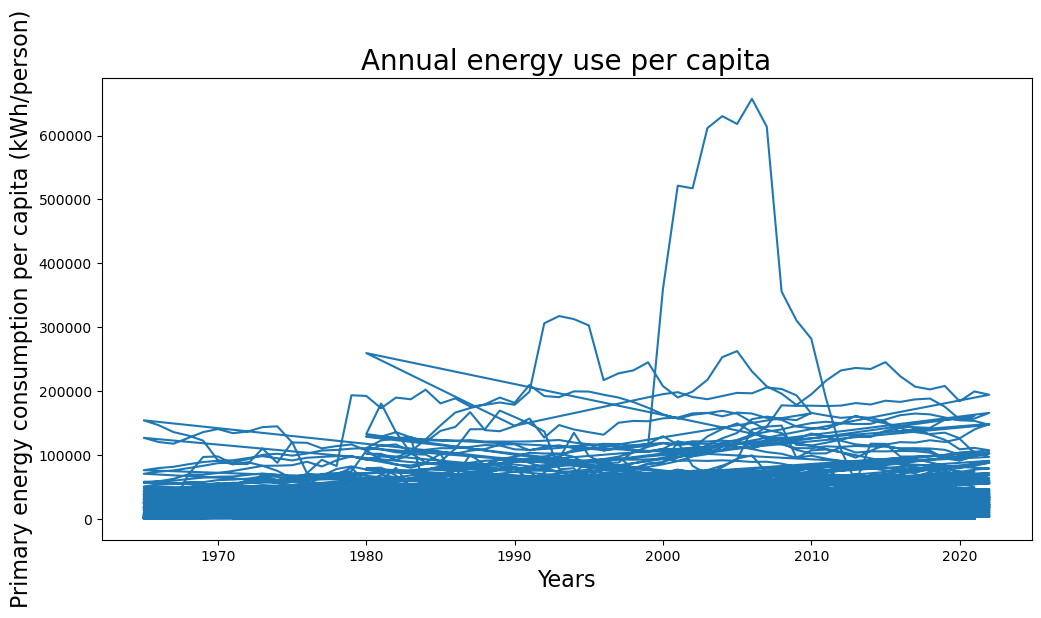

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

#Unsupervised learning technique

energy_data = pd.read_csv('per-capita-energy-use.csv')

plt.figure(figsize=(12,6))
plt.plot(energy_data['Year'],energy_data['Primary energy consumption per capita (kWh/person)'])
plt.xlabel('Years', fontsize=16)
plt.ylabel('Primary energy consumption per capita (kWh/person)', fontsize=16)
plt.title('Annual energy use per capita', fontsize=20)

### Show fig bases for different years

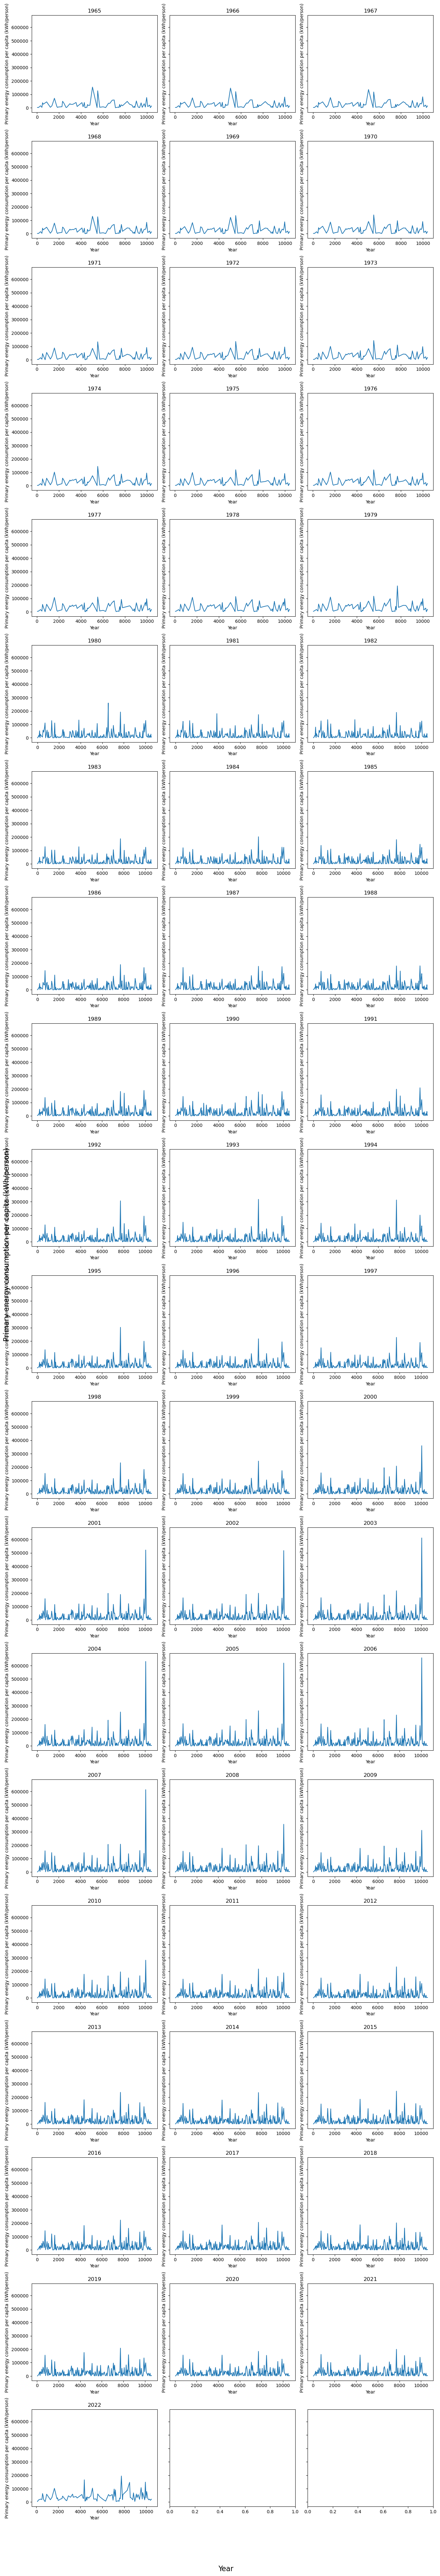

In [20]:
import numpy as np

years = np.sort(energy_data['Year'].unique())

# Create subplots
num_rows = (len(years) + 2) // 3  # Calculate the rows for subplots
fig, axs = plt.subplots(num_rows, 3, figsize=(16, 5 * num_rows), sharey=True)
fig.subplots_adjust(hspace=0.3, wspace=0.1)

# Plot electricity consumption for each year
for i, year in enumerate(years):
    row = i // 3
    col = i % 3
    year_data = energy_data[energy_data['Year'] == year]
    axs[row, col].plot(year_data['Primary energy consumption per capita (kWh/person)'])
    axs[row, col].set_title(year)
    axs[row, col].set_xlabel('Year')
    axs[row, col].set_ylabel('Primary energy consumption per capita (kWh/person)')

# Set common labels
fig.text(0.5, 0.09, 'Year', ha='center', fontsize=16)
fig.text(0.07, 0.5, 'Primary energy consumption per capita (kWh/person)', va='center', rotation='vertical', fontsize=16)

plt.show()

In [22]:
lst = np.sort(energy_data['Year'].unique())
average = []

for m in lst:
    # Filter energy_data for the current year
    yearly_data = energy_data[energy_data['Year'] == m]
    # Calculate the mean
    average_annually_consumption = yearly_data['Primary energy consumption per capita (kWh/person)'].mean()
    average.append(round(average_annually_consumption, 4))

average_table = pd.DataFrame({'Year': lst,'Average':average})
print(average_table)

    Year     Average
0   1965  22230.3079
1   1966  22741.7597
2   1967  23551.1877
3   1968  25351.9554
4   1969  26580.4827
5   1970  27539.5685
6   1971  27758.6636
7   1972  29058.6670
8   1973  30563.7074
9   1974  29824.8579
10  1975  29324.3895
11  1976  30096.4317
12  1977  31108.3428
13  1978  31975.8465
14  1979  34387.4944
15  1980  22439.6749
16  1981  21337.1989
17  1982  21078.3854
18  1983  20512.2883
19  1984  20607.7540
20  1985  22274.9920
21  1986  22452.1715
22  1987  23133.3632
23  1988  23749.6077
24  1989  24445.2379
25  1990  25292.0054
26  1991  24043.4858
27  1992  23514.3783
28  1993  23252.7854
29  1994  23461.6607
30  1995  23672.8690
31  1996  23334.8180
32  1997  23554.1539
33  1998  23609.5274
34  1999  23726.5285
35  2000  26426.9299
36  2001  27574.9306
37  2002  27814.9756
38  2003  28491.1331
39  2004  29312.9072
40  2005  29847.6182
41  2006  30284.3224
42  2007  30192.6750
43  2008  28954.2536
44  2009  27668.9166
45  2010  28335.6601
46  2011  268

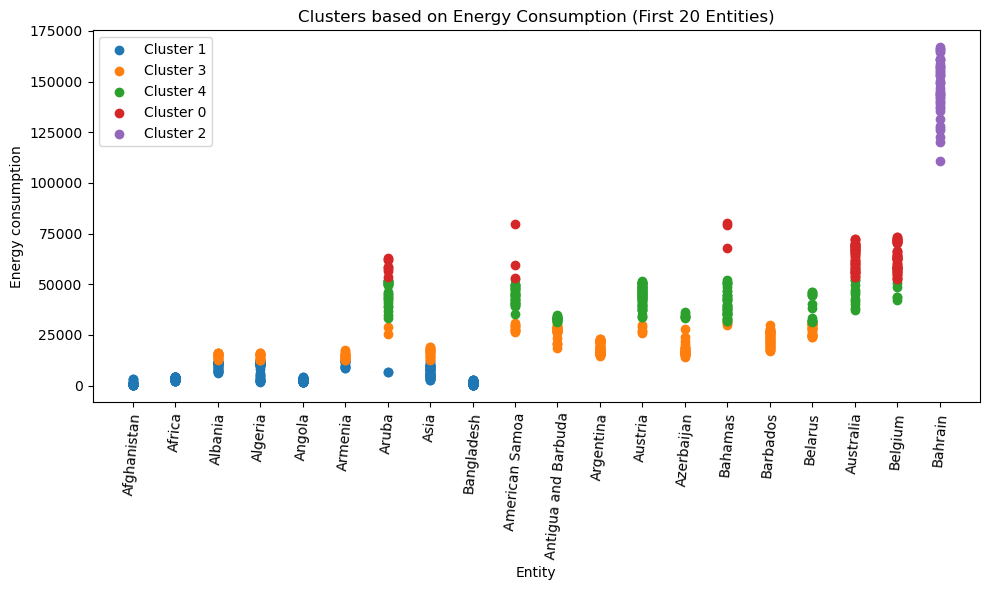

In [56]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

#Unsupervised learning technique

energy_data = pd.read_csv('per-capita-energy-use.csv')

# Select features
X = energy_data[['Entity', 'Primary energy consumption per capita (kWh/person)']]

# Filter the data for the first 20 entities
first_20_entities = X['Entity'].unique()[:20]
X_filtered = X[X['Entity'].isin(first_20_entities)].copy()

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtered[['Primary energy consumption per capita (kWh/person)']])

# Apply KMeans clustering 
num_clusters = 5  
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
X_filtered.loc[:, 'Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize the clusters
plt.figure(figsize=(10, 6))

for cluster in X_filtered['Cluster'].unique():
    cluster_data = X_filtered[X_filtered['Cluster'] == cluster]
    plt.scatter(cluster_data['Entity'], cluster_data['Primary energy consumption per capita (kWh/person)'], label=f'Cluster {cluster}')

plt.xlabel('Entity')
plt.ylabel('Energy consumption')
plt.title('Clusters based on Energy Consumption (First 20 Entities)')
plt.xticks(rotation=85)
plt.legend()
plt.tight_layout()
plt.show()

### Prediction by using Linear Regression

Mean Squared Error: 1224812620.026569
R-squared Score: -0.00098953042220562


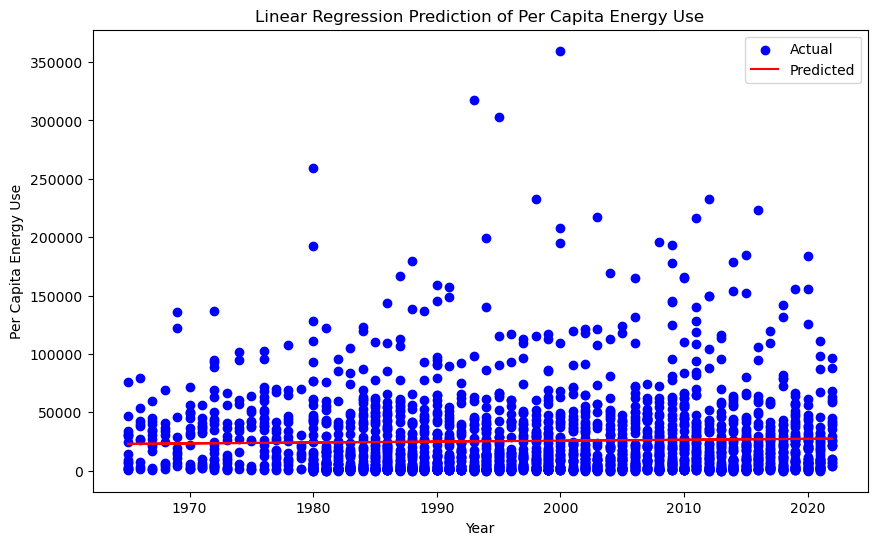

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

energy_data = pd.read_csv('per-capita-energy-use.csv')

# Extracting features and target variable
X = energy_data[['Year']]  # as the feature
y = energy_data['Primary energy consumption per capita (kWh/person)']  # Predict

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

# Visualize
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.plot(X_test, y_pred, color='red', label='Predicted')
plt.title('Linear Regression Prediction of Per Capita Energy Use')
plt.xlabel('Year')
plt.ylabel('Per Capita Energy Use')
plt.legend()
plt.show()

### Prediction by using Logistic Regression

Accuracy: 0.528052805280528

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.55      0.53      1039
           1       0.54      0.51      0.52      1082

    accuracy                           0.53      2121
   macro avg       0.53      0.53      0.53      2121
weighted avg       0.53      0.53      0.53      2121



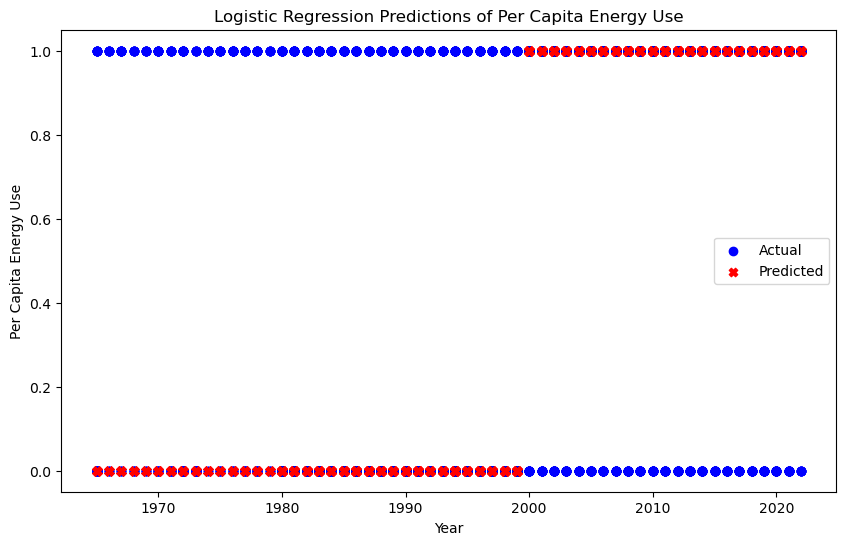

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Load the dataset
energy_data = pd.read_csv('per-capita-energy-use.csv')

# Extracting features and target variable
X = energy_data[['Year']]  # Use 'Year' as a feature
y = np.where(energy_data['Primary energy consumption per capita (kWh/person)'] > energy_data['Primary energy consumption per capita (kWh/person)'].median(), 1, 0)  # Classify based on median

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train a logistic regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Display
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.scatter(X_test, y_pred, color='red', marker='X', label='Predicted')
plt.title('Logistic Regression Predictions of Per Capita Energy Use')
plt.xlabel('Year')
plt.ylabel('Per Capita Energy Use')
plt.legend()
plt.show()

## Compare different solar compensation from global datasets

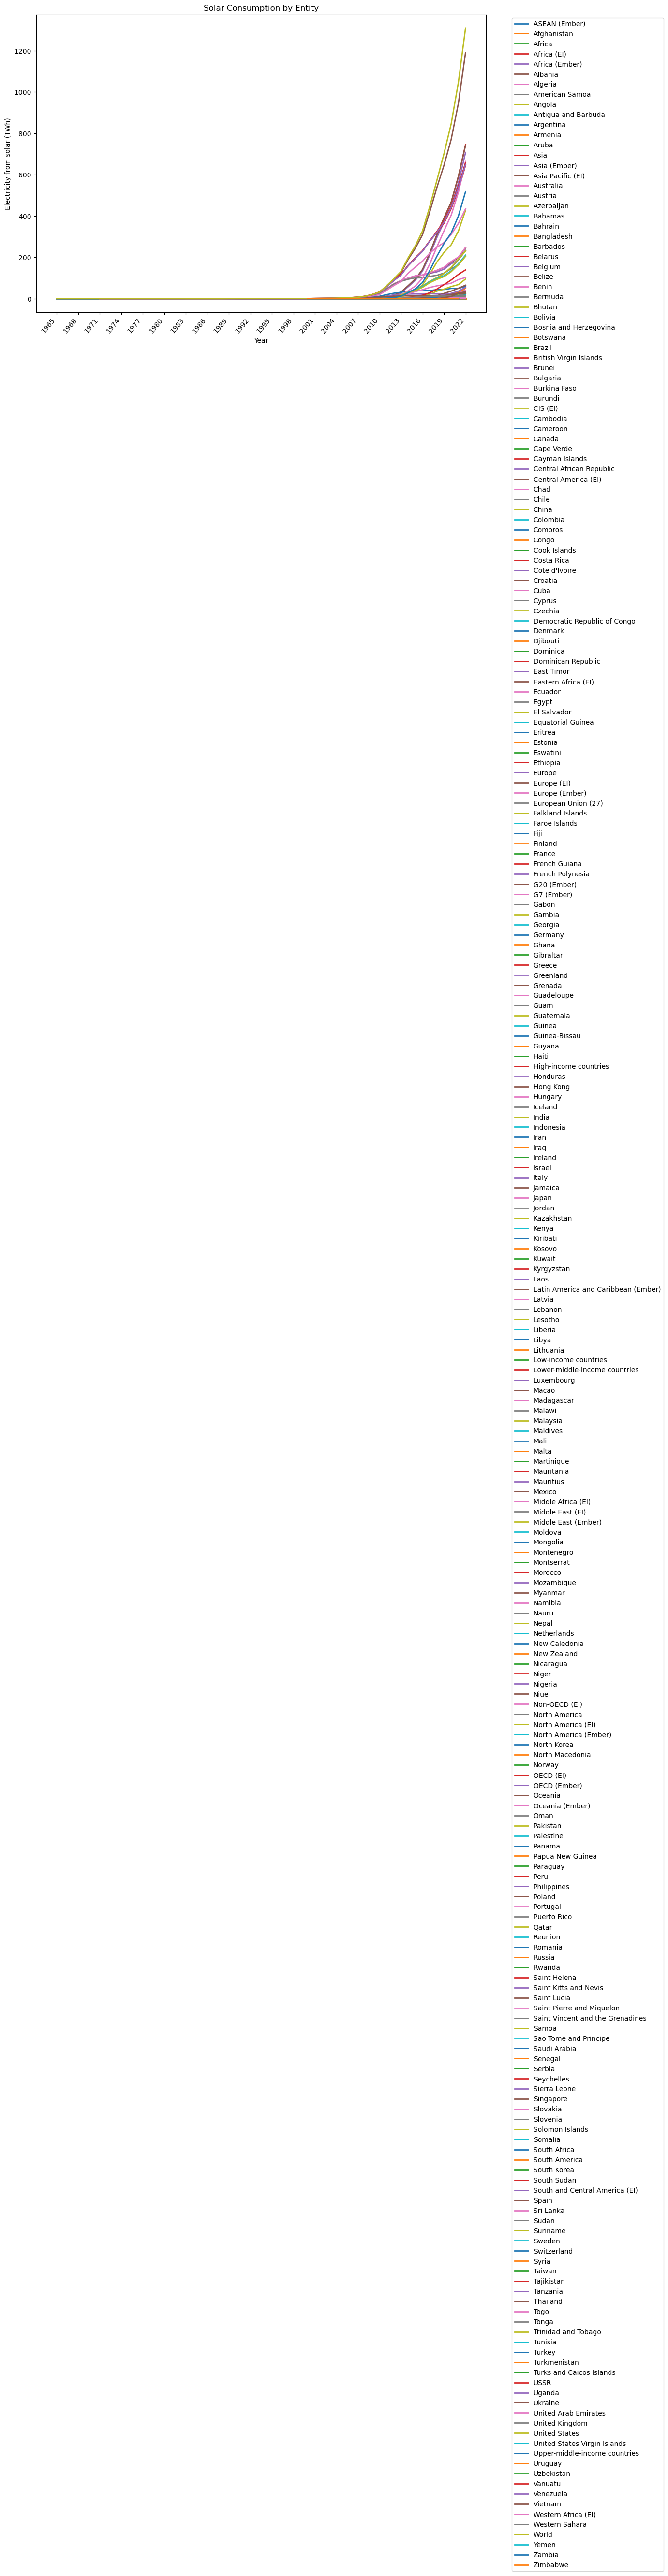

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
solar_energy_data = pd.read_csv('solar-energy-consumption.csv')

# Plot entity separately
plt.figure(figsize=(12, 8))

# Unique entities
for i, entity in enumerate(solar_energy_data['Entity'].unique()):
    entity_data = solar_energy_data[solar_energy_data['Entity'] == entity]
    plt.plot(entity_data['Year'], entity_data['Electricity from solar - TWh'], label=entity, linewidth=2)

plt.title('Solar Consumption by Entity')
plt.xlabel('Year')
plt.ylabel('Electricity from solar (TWh)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# In the range of 3
years = range(solar_energy_data['Year'].min(), solar_energy_data['Year'].max() + 1, 3)
plt.xticks(years, rotation=50, ha='right')


plt.show()

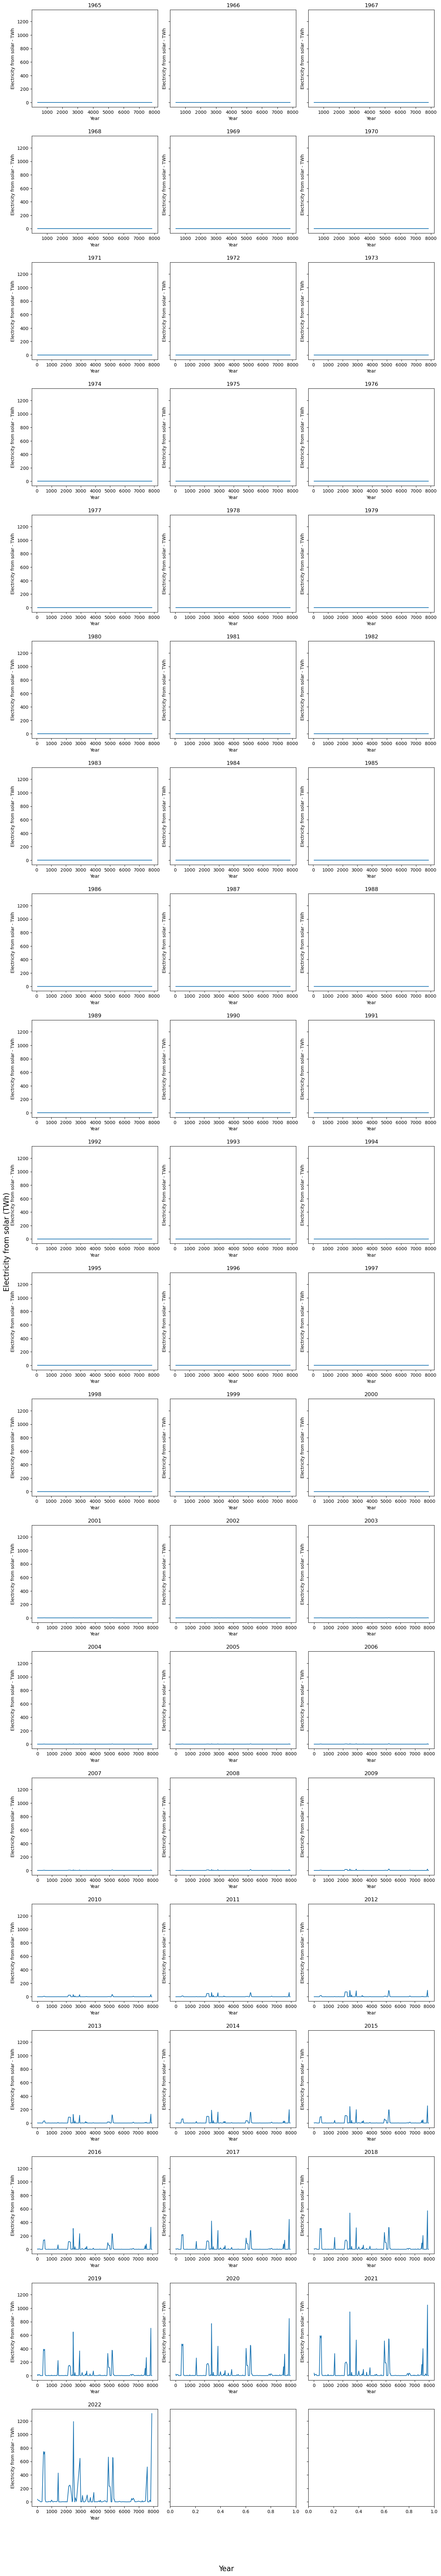

In [21]:
import numpy as np

years = np.sort(solar_energy_data['Year'].unique())

# Create subplots
num_rows = (len(years) + 2) // 3  # Calculate the number of rows needed for subplots
fig, axs = plt.subplots(num_rows, 3, figsize=(16, 5 * num_rows), sharey=True)
fig.subplots_adjust(hspace=0.3, wspace=0.1)

# Plot
for i, year in enumerate(years):
    row = i // 3
    col = i % 3
    year_data = solar_energy_data[solar_energy_data['Year'] == year]
    axs[row, col].plot(year_data['Electricity from solar - TWh'])
    axs[row, col].set_title(year)
    axs[row, col].set_xlabel('Year')
    axs[row, col].set_ylabel('Electricity from solar - TWh')

# Set common labels
fig.text(0.5, 0.09, 'Year', ha='center', fontsize=16)
fig.text(0.07, 0.5, 'Electricity from solar (TWh)', va='center', rotation='vertical', fontsize=16)

plt.show()

In [23]:
lst = np.sort(solar_energy_data['Year'].unique())
average = []

for m in lst:
    # Filter energy_data for the current year
    yearly_data = solar_energy_data[solar_energy_data['Year'] == m]
    # Calculate the mean
    average_annually_compensation = yearly_data['Electricity from solar - TWh'].mean()
    average.append(round(average_annually_compensation, 4))

average_table = pd.DataFrame({'Year': lst,'Average':average})
print(average_table)

    Year  Average
0   1965   0.0000
1   1966   0.0000
2   1967   0.0000
3   1968   0.0000
4   1969   0.0000
5   1970   0.0000
6   1971   0.0000
7   1972   0.0000
8   1973   0.0000
9   1974   0.0000
10  1975   0.0000
11  1976   0.0000
12  1977   0.0000
13  1978   0.0000
14  1979   0.0000
15  1980   0.0000
16  1981   0.0000
17  1982   0.0000
18  1983   0.0003
19  1984   0.0006
20  1985   0.0012
21  1986   0.0015
22  1987   0.0010
23  1988   0.0010
24  1989   0.0259
25  1990   0.0221
26  1991   0.0287
27  1992   0.0266
28  1993   0.0317
29  1994   0.0341
30  1995   0.0369
31  1996   0.0403
32  1997   0.0433
33  1998   0.0472
34  1999   0.0526
35  2000   0.0430
36  2001   0.0561
37  2002   0.0696
38  2003   0.0861
39  2004   0.1143
40  2005   0.1625
41  2006   0.2237
42  2007   0.3026
43  2008   0.4905
44  2009   0.8172
45  2010   1.3330
46  2011   2.6216
47  2012   4.0268
48  2013   5.4313
49  2014   7.8833
50  2015  10.0361
51  2016  12.6024
52  2017  16.7241
53  2018  21.1437
54  2019  

### Prediction by using Linear Regression

Mean Squared Error: 4055.137687374717
R-squared Score: 0.022147628287188303


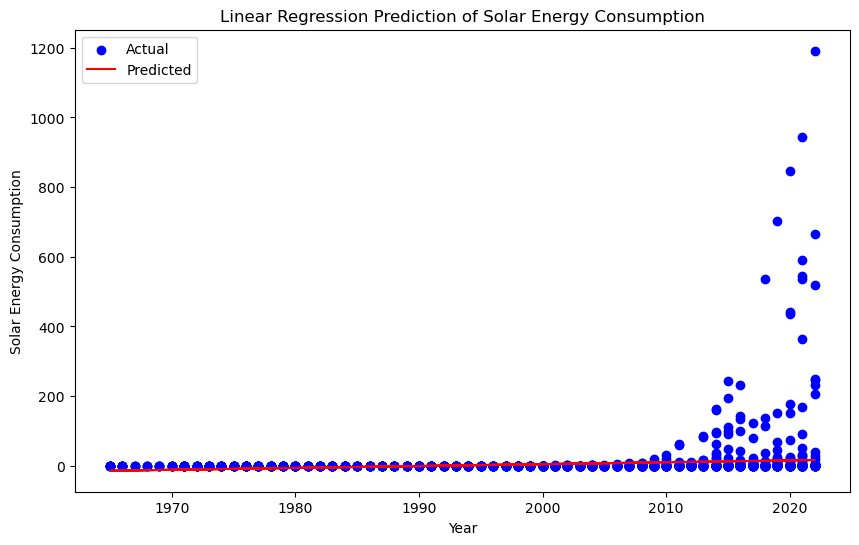

In [61]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
solar_energy_data = pd.read_csv('solar-energy-consumption.csv')

# Extracting features and target variable
X = solar_energy_data[['Year']]  # as the feature
y = solar_energy_data['Electricity from solar - TWh']  # Predict

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

# Visualize
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.plot(X_test, y_pred, color='red', label='Predicted')
plt.title('Linear Regression Prediction of Solar Energy Consumption')
plt.xlabel('Year')
plt.ylabel('Solar Energy Consumption')
plt.legend()
plt.show()